In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customer= pd.read_pickle('modifiedCus.pkl')
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        5630 non-null   object 
 1   PreferredLoginDevice         5630 non-null   object 
 2   CityTier                     5630 non-null   float64
 3   PreferredPaymentMode         5630 non-null   object 
 4   Gender                       5630 non-null   object 
 5   NumberOfDeviceRegistered     5630 non-null   float64
 6   PreferedOrderCat             5630 non-null   object 
 7   SatisfactionScore            5630 non-null   float64
 8   MaritalStatus                5630 non-null   object 
 9   NumberOfAddress              5630 non-null   int64  
 10  Complain                     5630 non-null   object 
 11  CashbackAmount               5630 non-null   float64
 12  Tenure                       5630 non-null   float64
 13  WarehouseToHome   

##### I. Data Cleaning
- Using statistics to define normal data and identify outliers
- Imputing missing values using statistics or a learned Model 

##### II. Feature Selections

the supervised techniques can be further divided into models that automatically select features as part of fitting the model (intrinsic), those that explicitly choose features that result in the best performing model (wrapper) and those that score each input feature and allow a subset to be selected (filter).

##### III. Data Transformation 


In [3]:
sns.set_style('darkgrid')
np.set_printoptions(precision=2)
import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [7]:
# Categorical and numerical variables 
var_cate = [col for col in customer.columns if customer[col].dtype == 'object' and col != 'Churn']
var_nume = [col for col in customer.select_dtypes(include=['int64', 'float64']).columns if col != 'Churn']

print(var_cate)
print('------------')
print(var_nume)

['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus', 'Complain']
------------
['CityTier', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'CashbackAmount', 'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']


In [5]:
# Models to check 
seed= 961
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))
models.append(('XGB', XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')))
models.append(('ADA', AdaBoostClassifier(random_state=seed)))

In [11]:
results = []
names = []
xVar, yVar= customer.drop(['Churn'], axis=1), customer['Churn']
labelencoder= LabelEncoder()
yVar= labelencoder.fit_transform(yVar)
# ColumnTransformer to apply OneHot encoding to categorical variables and scaling to numeric variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), var_nume),
        ('cat', OneHotEncoder(), var_cate)
    ])

for name, model in models:
    # Creates a pipeline with SMOTE and the estimator
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=961)),
        (name, model)
    ])
    
    # 10-fold cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=961)
    result = cross_val_score(pipeline, xVar, yVar, cv=cv, scoring='roc_auc')
    
    results.append(result)
    names.append(name)

In [12]:
# Average result of each model 
mean_results = [result.mean() for result in results]
# Creates a dictionary to relate model names to their mean results
model_mean_results = dict(zip(names, mean_results))

# Prints the average results of each model
for model_name, mean_result in model_mean_results.items():
    print(f'{model_name}: Mean Accuracy = {mean_result:.4f}')

LR: Mean Accuracy = 0.8968
LDA: Mean Accuracy = 0.8963
KNN: Mean Accuracy = 0.9913
DTC: Mean Accuracy = 0.9340
NB: Mean Accuracy = 0.8136
RFC: Mean Accuracy = 0.9948
SVM: Mean Accuracy = 0.9706
GBC: Mean Accuracy = 0.9352
XGB: Mean Accuracy = 0.9954
ADA: Mean Accuracy = 0.9061


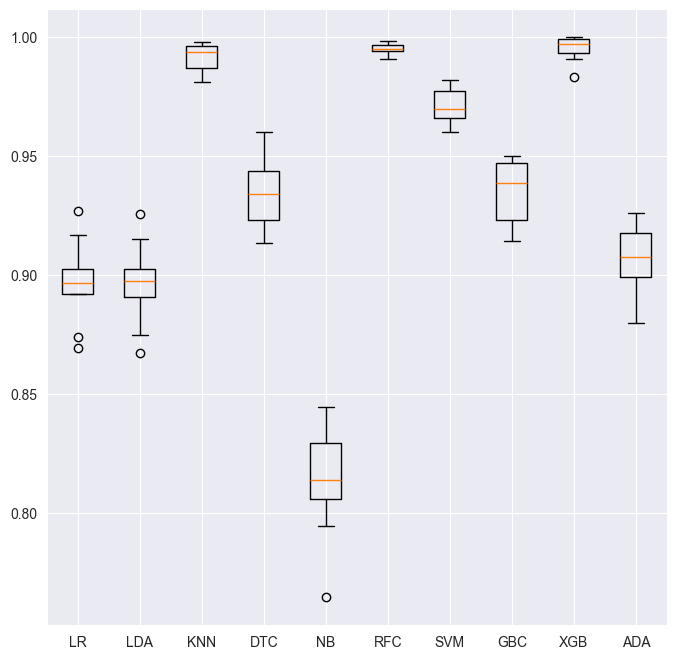

In [13]:
def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()
boxplots_algorithms(results, names)

<div class="alert alert-block alert-info">
<b>Best Performing Algorithm</b> Extreme Gradient Boosting with 99.54% Accuracy</div>



In [17]:
# Grid Search to find the best parameters
# Defines a range of values for different hyperparameters
param_grid = {
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [4, 5, 6],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9],
    'xgb__n_estimators': [200, 300, 400],
    'xgb__objective': ['binary:logistic']
}

# Creates an XGBClassifier object
xgb = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss')

# Creates a pipeline with SMOTE
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=seed)),
    ('xgb', xgb)
])

# Creates GridSearchCV object with ROC-AUC as scoring metric
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed), 
    n_jobs=-1, 
    scoring='roc_auc', 
    verbose=1
)

# Fits the grid search to the data
grid_search.fit(xVar, yVar)

# Gets the best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [18]:
print(f"Best Parameters: {best_parameters}")
print()
print(f"Best Score: {best_score}")

Best Parameters: {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 400, 'xgb__objective': 'binary:logistic', 'xgb__subsample': 0.9}

Best Score: 0.9928437789188786


In [19]:
X_train, X_test, y_train, y_test = train_test_split(xVar, yVar, test_size=0.2, random_state=seed)

# Creates a pipeline with preprocessing, SMOTE, and XGBoost classifier
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=seed)),
    ('xgb', XGBClassifier(
        colsample_bytree=0.7,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=400,
        objective='binary:logistic',
        subsample=0.9,
        random_state=seed,
        use_label_encoder=False,
        eval_metric='logloss'))
])

# Fits the pipeline to the training data
final_pipeline.fit(X_train, y_train)

# Makes predictions on the training and test data
y_pred_train = final_pipeline.predict(X_train)
y_pred_test = final_pipeline.predict(X_test)

# Calculates accuracy on training and test sets
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Prints the accuracies
print(f"Training Set Accuracy: {accuracy_train:.4f}")
print(f"Test Set Accuracy: {accuracy_test:.4f}")

Training Set Accuracy: 1.0000
Test Set Accuracy: 0.9805


Specificity/Recall or True Negative (TN): 98.82% of the cases were correctly predicted as not churning.
False Negative (FN): 12.31% of the cases were incorrectly predicted as not churning when they actually were (these are clients that churned but the model predicted they wouldn't).
Sensitivity or True Positive (TP): 87.69% of the cases were correctly predicted as churning.
False Positive (FP): 1.18% of the cases were incorrectly predicted as churning when they actually were not.

Implications for the company:

The model has a high True Negative rate, meaning it is very good at identifying customers who are not at risk of churning.
The True Positive rate is also quite high, indicating that the model is fairly effective at identifying customers who will churn. Since the main goal is to identify true positives, having 87.69% is good, but there is still room for improvement.
The False Negative rate is 12.31%, which is a concern since these are customers who the model predicts will stay but actually leave. This is particularly important for the business, as these are missed opportunities for intervention.
The False Positive rate is low, which is good because it means the model does not often incorrectly flag customers as at risk of churning when they are not. However, interventions on these customers may lead to unnecessary costs.

Confusion Matrix:
 [[933  10]
 [ 12 171]]


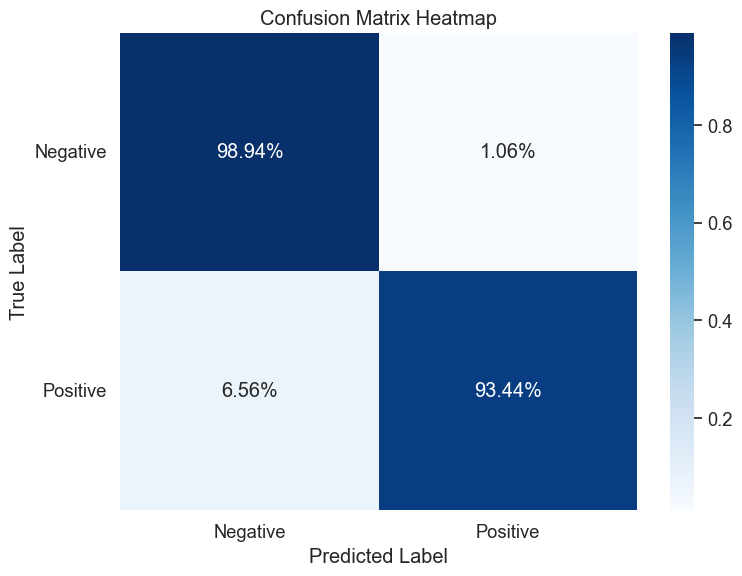

In [20]:
# Calculates the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Prints the confusion matrix
print("Confusion Matrix:\n", cm)

# Normalizes the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Confusion Matrix labels 
labels = ['Negative', 'Positive']
categories = ['Negative', 'Positive']

# Heat Map with ratios
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(ticks=np.arange(0.5, 2.5), labels=categories, rotation=0)
plt.yticks(ticks=np.arange(0.5, 2.5), labels=categories, rotation=0)
plt.tight_layout()
plt.show()

In [22]:
# Get the feature importances from the xgb step in the pipeline
importances = final_pipeline.named_steps['xgb'].feature_importances_

#Creates a dictionary that maps the feature name to its importance
feature_importance_dict = dict(zip(xVar.columns, importances))

# Sorts features by importance (from highest to lowest)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Prints the features and their importance
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: PreferedOrderCat, Importance: 0.10054158419370651
Feature: CityTier, Importance: 0.03193782642483711
Feature: Gender, Importance: 0.030832333490252495
Feature: Complain, Importance: 0.026014205068349838
Feature: Tenure, Importance: 0.02258414216339588
Feature: DaySinceLastOrder, Importance: 0.022134890779852867
Feature: CouponUsed, Importance: 0.02209199033677578
Feature: PreferredPaymentMode, Importance: 0.020616315305233
Feature: PreferredLoginDevice, Importance: 0.02022748626768589
Feature: WarehouseToHome, Importance: 0.018830878660082817
Feature: OrderAmountHikeFromlastYear, Importance: 0.017863405868411064
Feature: HourSpendOnApp, Importance: 0.017335696145892143
Feature: CashbackAmount, Importance: 0.01719258539378643
Feature: SatisfactionScore, Importance: 0.012567867524921894
Feature: NumberOfAddress, Importance: 0.01151143480092287
Feature: MaritalStatus, Importance: 0.010778361931443214
Feature: OrderCount, Importance: 0.009311332367360592
Feature: NumberOfDeviceReg

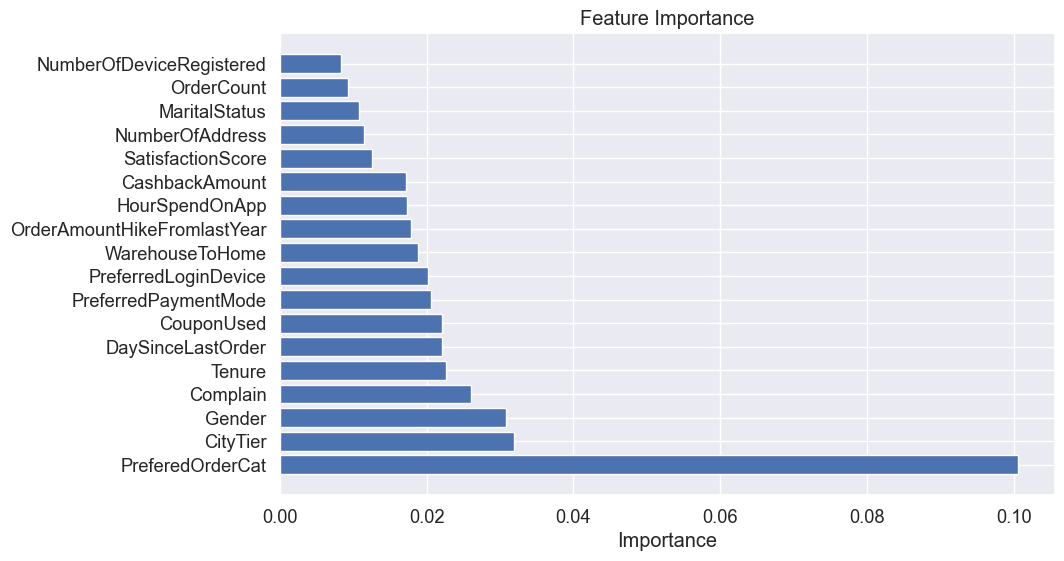

In [23]:
# Feature names and their importances sorted
sorted_feature_names, sorted_importances = zip(*sorted_features)

# Barplot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()